In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
#pip install pytorch-lightning  
# pip install ipywidgets

Populating the interactive namespace from numpy and matplotlib


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 13 03:17:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    22W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#install pyg
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 29.5 MB/s eta 0:00:00


# Force graph layout
just minimize the following loss
$$ \mathcal{L} = \mathrm{Tr}[X^TLX] + V(X)= \sum_{ij} A_{ij}\|X_i-X_j\|^2 + V(X)$$

## Using GCN
The trcick is to express the positions X as the output of a graph conv. net. 
To do this, we start from a high dim embedding and pass through a GCN

## Stopping criterion
We don't want to use the absolute value of loss, as there may be a large offset. 
Instead we choose two distant indices in loss history, says -1 and -1000, and compare the change over the large period with recent changes, e.g. std over the past 20 steps. 
To stop when fluctuations are large, we will compare the mean over first half and second half of a recent interval. 
For exmaple, the interval may have length 64 steps. 
We compare change in loss between mean over the latter 32 steps with loss over first 32 steps. 
We should do this periodically, not every step, for efficiency.

In [68]:
from torch_geometric.nn.pool import radius
import torch
from torch import nn

import os
import time

V = lambda x: x.detach().cpu().numpy()
from numpy import newaxis, mean, savetxt
import networkx as nx

from scipy import spatial
from scipy.spatial import cKDTree

#GCN -----------
from torch_geometric.nn import GCNConv

#GAT ----------
from torch_geometric.nn import GATConv

#GN -----------
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean

class NodeModel(torch.nn.Module):
    def __init__(self, in_feat, out_feat):
        super().__init__()

        self.in_feat = in_feat
        self.out_feat = out_feat

        self.node_mlp_1 = Seq(Lin(self.in_feat, self.in_feat, bias = False), ReLU(), Lin(self.in_feat, self.in_feat, bias = False))
        self.node_mlp_2 = Seq(Lin(2*self.in_feat, self.in_feat, bias = False), ReLU(), Lin(self.in_feat, self.out_feat, bias = False))

    def forward(self, x, edge_index):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = x[row]
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        
        return self.node_mlp_2(out)
    

#Loss function -----------

MIN_REPUL_DIST = 1e-3
radius = .4
magnitude = 10

def Repulsion(X):
    # assuming X: (n,d)
    dX = X[newaxis] - X[:,newaxis] # (n,n,d)
    # have to remove the diagonal (self-loops)
    # dX shouldn't be calc'd for self. 
    # mask = torch.ones(len(X), len(X))- torch.eye(len(X))
    #return torch.sum(1/ (MIN_REPUL_DIST + torch.norm(dX, dim=(-1))))

    r = torch.sum( dX**2, dim = -1)
    return magnitude*torch.sum(torch.exp( -r/4/(radius**2) ))



def Elastic(X, A):
    D = torch.diag(torch.sum(A,dim = 1))
    # Laplacian
    L = D - A 
    return torch.trace(X.t() @ L @ X)

def Loss(X,A,c=1):
    return Elastic(X,A) + c * Repulsion(X)


def Elastic_edgelist(X, edg):
    # if edg.shape[-1] == 2:
    return torch.sum((X[edg[:,0]]-X[edg[:,1]])**2)/2
    
def Loss_edgelist(X,edg,c=1):
    return Elastic_edgelist(X,edg) + c * Repulsion(X)


#Alternative GCN models ----------- 
class GCN(nn.Module):
    def __init__(self, in_feat, out_feat, A=None, edgelist=None, N=None):
        """A: Adjacency matrix 
        if A is gven, edgelist ignored. 
        If edglelist given, max index in edgelist is assumed to be number of nodes N, unless N is given. 
        """
        super(GCN,self).__init__()
        if A!=None:
            self.A = torch.as_tensor(A)
        elif len(edgelist): 
            raise
            
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.W = nn.Parameter(torch.empty(in_feat, out_feat))
        nn.init.kaiming_normal_(self.W)
        
    def forward(self, x):
        return self.A @ x @ self.W


class GCN_Lowrank(nn.Module):
    def __init__(self, in_feat, out_feat, A=None, pc_num_frac = 0.1, 
                 edgelist=None, N=None):
        """A: Adjacency matrix 
        if A is gven, edgelist ignored. 
        If edglelist given, max index in edgelist is assumed to be number of nodes N, unless N is given. 
        """
        super(GCN_Lowrank,self).__init__()
        if A!=None:
            self.A = torch.as_tensor(A)
            self._prep_A_lowrank(A, pc_num_frac)
        elif len(edgelist): 
            raise
            
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.W = nn.Parameter(torch.empty(in_feat, out_feat))
        nn.init.kaiming_normal_(self.W)
        
    def _prep_A_lowrank(self, A, pc_num_frac):
        A = torch.as_tensor(A)
        A = (A+A.t())/2
        v,p = torch.linalg.eigh(A)
        k = int(pc_num_frac * len(A))
        idx = torch.argsort(v, descending=True)[:k]
        self.pval, self.pvec = v[:k], p[:,:k]
        self.pvec_tv = (self.pvec * self.pval).t()
        
    def agg(self,x):
        x = self.pvec_tv @ x
        return self.pvec @ x
            
    def forward(self, x):
        # return self.A @ x @ self.W
        return self.agg(x) @ self.W

    
def time_it(f):
    def dt(*args, **kw):
        t0 = time.time()
        a = f(*args, **kw)
        print('%s time: %.3g s'%(f.__name__,time.time()-t0))
        # return a
    return dt

#NeuLay model -----------

class ResGCN(nn.Module):
    def __init__(self, feat_dims = [1,1], A=None, edge_index = None, edgelist=None, normalize_A = True,
                activation = None, device = None, lr = 1e-2, GCN_class = GCN):
        super(ResGCN,self).__init__()
        if device==None:
            device = ('cuda' if torch.cuda.is_available() else 'cpu')
            print(device)
        self.device = torch.device(device)
        
        if edgelist!=None:
            self.edgelist = torch.tensor(edgelist, dtype = torch.long).to(self.device) 
            A = torch.zeros(n,n, dtype = torch.float32).to(self.device)
            for i,j in self.edgelist:
                A[i,j] = 1
                # A[j,i] = 1 
            self.Loss = lambda x: Loss_edgelist(x,self.edgelist)
            self.A = torch.as_tensor(A).to(self.device)
        
        elif A!=None:
            self.A = torch.as_tensor(A).to(self.device)
            self.Loss = lambda x: Loss(x, self.A)
            
        self.edge_index = edge_index.to(self.device)
        
        if normalize_A:
            degs = self.A.sum(dim=1) 
            self.DA = torch.diag(1/(1e-1+degs)) @ self.A 
        else:
            self.DA = self.A
            
        n = len(self.A)
        # =====  Module Parameters ======
        self.latent = nn.Parameter(torch.empty(n,feat_dims[0]).to(self.device))
        r = n**(1./feat_dims[0])
        print("latent radius {:.3g}".format(r))
        nn.init.normal_(self.latent,std = r)
        
        #self.gcn_list = nn.ModuleList([GCN_class(feat_dims[i], feat_dims[i+1], A=self.DA).to(self.device)
         #                              for i in range(len(feat_dims)-2)])

        if GCN_class == 'GCNConv':
          self.gcn_list = nn.ModuleList([GCNConv(feat_dims[i], feat_dims[i+1], improved= True, bias = False ).to(self.device)
                                        for i in range(len(feat_dims)-2)])
        if GCN_class == 'GATConv':
          self.gcn_list = nn.ModuleList([GATConv(feat_dims[i], feat_dims[i+1], bias = False).to(self.device)
                                         for i in range(len(feat_dims)-2)])

        if GCN_class == 'GraphNet':
          self.gcn_list = nn.ModuleList([NodeModel(feat_dims[i], feat_dims[i+1]).to(self.device)
                                         for i in range(len(feat_dims)-2)])
        
        
        self.projection_layer = (nn.Linear(sum(feat_dims[:-1]), feat_dims[-1]).to(self.device)
                                 if len(feat_dims)>1 else nn.Identity())
        self.loss_history = []
        self.optim = torch.optim.Adam(self.parameters(), lr = lr/2)
        
        self.fine_pos = nn.Parameter(torch.empty(n,feat_dims[-1]).to(self.device))
        nn.init.normal_(self.fine_pos,std = r)
        self.optim_fine = torch.optim.Adam([self.fine_pos], lr = lr)
        
    def forward(self,):
        out = [self.latent]
        for g in self.gcn_list:
            out += [g(out[-1], self.edge_index)]
        out = torch.concat(out,dim = 1)
        out = self.projection_layer(out)
        return out
    
    @time_it
    def train(self,gcn_steps=200, fdl_steps=2000, early_stop_check_steps = 100, 
              min_steps=100, #stop_delta_ratio = 5e-3, 
              gcn_stop_threshold = 2e-2,
              fdl_stop_threshold = 5e-3,
              **stop_kws):
        """train(self,gcn_steps=200, fdl_steps=2000, early_stop_check_steps = 100, 
              min_steps=100, #stop_delta_ratio = 5e-3, 
              gcn_stop_threshold = 2e-2,
              fdl_stop_threshold = 5e-3,
              **stop_kws):
        """
        try:
            if gcn_steps > 0 and len(self.gcn_list) > 0:
                self.train_gcn(steps=gcn_steps, early_stop_check=early_stop_check_steps, 
                               min_steps=min_steps, 
                               stop_delta_ratio=gcn_stop_threshold, **stop_kws)
                self.fine_pos.data = self()
            print(f'\nFDL training {fdl_steps} steps')
            self.train_fine(steps=fdl_steps, early_stop_check=early_stop_check_steps, 
                            min_steps=min_steps, 
                            stop_delta_ratio=fdl_stop_threshold, **stop_kws)
        except KeyboardInterrupt:
            print('\nTraining interrupted')
            return
        
    
    @time_it
    def train_gcn(self,steps = 100, early_stop_check = 100, min_steps=100, stop_delta_ratio = 5e-3, **stop_kws):
        for i in range(steps):
            self.optim.zero_grad()
            # loss = Loss(self(), self.A)
            loss = self.Loss(self())
            loss.backward() 
            self.loss_history += [loss.item()+0.]
            self.optim.step()
            if i> min_steps and i % early_stop_check == 1:
                # print('checking', i)
                if early_stopping(self.loss_history,stop_delta_ratio=stop_delta_ratio, **stop_kws): 
                    print('\n===========\nstopping at step ',i)
                    break
    
    @time_it    
    def train_fine(self,steps = 100, early_stop_check = 100, min_steps=100, stop_delta_ratio = 5e-3, **stop_kws):
        for i in range(steps):
            self.optim_fine.zero_grad()
            # loss = Loss(self.fine_pos, self.A)
            loss = self.Loss(self.fine_pos)
            loss.backward() 
            self.loss_history += [loss.item()+0.]
            self.optim_fine.step()
            if i> min_steps and i % early_stop_check == 1:
                # print('checking', i)
                if early_stopping(self.loss_history,stop_delta_ratio=stop_delta_ratio, **stop_kws): 
                    print('\n===========\nstopping at step ',i)
                    break
                    
    def get_node_pos(self):
        return self.fine_pos
    
    def save_layout(self,save_dir='./', save_name = 'nodes', delimiter=','):
        """saves a nodes.csv """
        pos = V(self.get_node_pos())
        os.makedirs(save_dir, exist_ok=True)
        savetxt(os.path.join(save_dir, save_name+'.csv'), pos, delimiter=delimiter)
        
        # TBA: create edgelist if not made
        # savetxt(os.path.join(save_dir, 'edges.csv'), self.edgelist, delimiter=delimiter)
            
            

def early_stopping(metric_list,
            small_window = 32,
            big_window = 1000,
            stop_delta_ratio = 1e-3, verbose=True):
    if len(metric_list) < 2*small_window:
        return False
    # check if chenges within big window and small window are smaller then the ratio
    big_window = max(big_window, 2*small_window)
    last = mean(metric_list[-small_window:])
    dl_small =  abs(last - mean(metric_list[-2*small_window:-small_window]))
    idx = max(0,len(metric_list)-big_window)
    dl_big = abs(last - mean(metric_list[idx:idx+small_window]))
    ratio = dl_small / dl_big
    if verbose: 
        print(f'step: {len(metric_list)}, Loss change ratio: {ratio:.3g}', end='\r')
        # print(f'Loss change ratio: {ratio:.3g}', end='\r')
    return ratio < stop_delta_ratio 

def plot_layout(res, dims=[0,1], edges=True, node_kws={}, edg_kws=dict(c='k',lw=.5)):
    x = res.get_node_pos()
    # subplot(aspect='equal')
    scatter(*V(x).T[dims], zorder = 1000, **node_kws)
    if edges: 
        for i,j in  zip(*torch.where(res.A)):
            plot(*V(x[[i.item(),j.item()]]).T[dims], **edg_kws)

Read json file & connect to the data folder

In [6]:
#connect to the drive folder

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import json
from networkx.readwrite import json_graph

def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

#g = read_json_file('/content/drive/MyDrive/GCN_reparametrization/data/internet2006_relabeled.json')

In [ ]:
# Space dimensions
DIMENSIONS = 3

# choose GCN small steps
MAX_GCN_STEPS = int(2e3)

# fine-tuning FDL steps. make large
MAX_FDL_STEPS = int(2e4)

# early stopping (lower = runs longer)
GCN_STOP_THRESHOLD = 5e-3
FDL_STOP_THRESHOLD = 2e-3


In [ ]:
files = ['rgg_n1000.json','ba_n1000.json','er_n1000.json','rgg_n5000.json','ba_n5000.json','er_n5000.json','rgg_n10000.json', 'ba_n10000.json','er_n10000.json', 'rgg_n15000.json', 'ba_n15000.json','er_n15000.json']#, 'rgg_n20000.json', 'ba_n20000.json','er_n20000.json' ]

e = 3


In [ ]:
results = []

for f in files:
  g = read_json_file('/content/drive/MyDrive/GCN_reparametrization/data/%s'%f)

  n = len(g.nodes())
  # adjacency matrix
  a = torch.zeros(n,n)
  identity = torch.eye(n)
  # edgelist  
  edg = []
  for k,v in g.adj.items():
      for i in v:
          a[k,i] = 1
          edg += [[k,i]]

  edge_index = torch.tensor(edg).T

  for run in range(e):
    ###
    #layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-1, GCN_class='GCNConv')
    
    #start_time = time.time()
    #layout.train(gcn_steps=0, fdl_steps=MAX_FDL_STEPS, 
    #      early_stop_check_steps = 100, 
    #      min_steps=200, 
    #      gcn_stop_threshold = GCN_STOP_THRESHOLD,
    #      fdl_stop_threshold = FDL_STOP_THRESHOLD,
    #     )
    #results += [[ 'FDL', time.time() - start_time, layout.loss_history[-1] ]] 

    #layout.save_layout(save_dir='/content/drive/MyDrive/GCN_reparametrization/data', save_name = 'FDL_short_'+f+str(run) )
    
    ###
    layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-1, GCN_class='GraphNet')

    start_time = time.time()  
    layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, 
          early_stop_check_steps = 100, 
          min_steps=200, 
          gcn_stop_threshold = GCN_STOP_THRESHOLD,
          fdl_stop_threshold = FDL_STOP_THRESHOLD,
         )
    
    results += [[ 'GraphNet', time.time() - start_time, layout.loss_history[-1] ]] 
    
    layout.save_layout(save_dir='/content/drive/MyDrive/GCN_reparametrization/data', save_name = 'GraphNet_short_'+f+str(run) )


    ###
    #layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-1, GCN_class='GCNConv')

    #start_time = time.time()  
    #layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, 
    #      early_stop_check_steps = 100, 
    #      min_steps=200, 
    #      gcn_stop_threshold = GCN_STOP_THRESHOLD,
    #      fdl_stop_threshold = FDL_STOP_THRESHOLD,
    #     )
    
    #results += [[ 'GCN', time.time() - start_time, layout.loss_history[-1] ]] 
    
    #layout.save_layout(save_dir='/content/drive/MyDrive/GCN_reparametrization/data', save_name = 'GCN_short_'+f+str(run) )

    ###
    #layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-1, GCN_class='GATConv')
    
    #start_time = time.time()
    #layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, 
    #      early_stop_check_steps = 100, 
    #      min_steps=200, 
    #      gcn_stop_threshold = GCN_STOP_THRESHOLD,
    #      fdl_stop_threshold = FDL_STOP_THRESHOLD,
    #     )

    #results += [[ 'GAT', time.time() - start_time, layout.loss_history[-1] ]] 

    #layout.save_layout(save_dir='/content/drive/MyDrive/GCN_reparametrization/data', save_name = 'GAT_short_'+f+str(run) )

    ###
    #layout = ResGCN(feat_dims=[10,10,DIMENSIONS], A= identity, edge_index=edge_index, lr=1e-1, GCN_class='GCNConv')
    
    #start_time = time.time()
    #layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, 
    #      early_stop_check_steps = 100, 
    #      min_steps=200, 
    #      gcn_stop_threshold = GCN_STOP_THRESHOLD,
    #      fdl_stop_threshold = FDL_STOP_THRESHOLD,
    #     )
    
    #results += [[ 'Deep_1', time.time() - start_time, layout.loss_history[-1] ]]


    #layout.save_layout(save_dir='/content/drive/MyDrive/GCN_reparametrization/data', save_name = 'Deep'+f+str(run) )


In [8]:
import pandas as pd

In [ ]:
out = pd.DataFrame(results, columns=['type', 'time', 'energy'])
out.to_csv('/content/drive/MyDrive/GCN_reparametrization/results_graphnet_short.csv', index=False)

# Test: Barabasi-Albert Network

In [76]:
n,m = 100, 3
g = nx.barabasi_albert_graph(n,m)
#g = nx.random_geometric_graph(n, radius = 0.35 ,dim = 3)

n = len(g.nodes())
# adjacency matrix
a = torch.zeros(n,n)
identity = torch.eye(n)
# edgelist
edg = []
for k,v in g.adj.items():
    for i in v:
        a[k,i] = 1
        edg += [[k,i]]
    

In [77]:
edge_index = torch.tensor(edg).T
edge_index.shape

torch.Size([2, 14058])

In [78]:
nx.is_connected(g)

True

# Layout Options

In [79]:
# Space dimensions
DIMENSIONS = 3

# choose GCN small steps
MAX_GCN_STEPS = int(2e3)

# fine-tuning FDL steps. make large
MAX_FDL_STEPS = int(2e4)

# early stopping (lower = runs longer)
GCN_STOP_THRESHOLD = 5e-3
FDL_STOP_THRESHOLD = 2e-4



In [80]:
layout = ResGCN(feat_dims=[10,10, DIMENSIONS], A= a, edge_index=edge_index, lr=1e-1, GCN_class='GCNConv')
#layout = ResGCN(feat_dims=[100,100,DIMENSIONS], A= a, edge_index=edge_index, lr=1e-1, GCN_class='GraphNet')

cuda
latent radius 2.39


step: 502, Loss change ratio: 0.00499
stopping at step  501
train_gcn time: 23.1 s

FDL training 20000 steps

Training interrupted
train time: 195 s


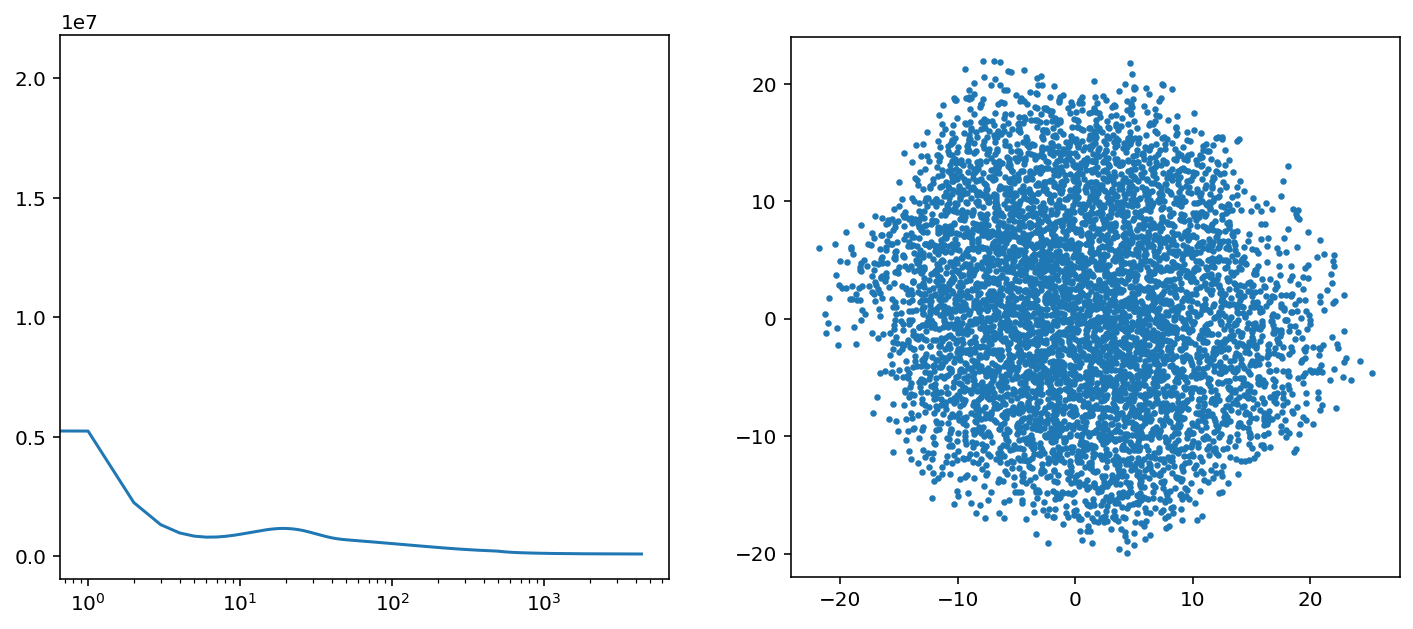

In [81]:
layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, 
          early_stop_check_steps = 100, 
          min_steps=200, 
          gcn_stop_threshold = GCN_STOP_THRESHOLD,
          fdl_stop_threshold = FDL_STOP_THRESHOLD,
         )

figure(figsize=(12,5))
subplot(121)
plot(layout.loss_history)
xscale('log')
subplot(122, aspect='equal')
plot_layout(layout, edges=False, node_kws={'s':5})

In [82]:
layout.save_layout(save_dir='/content/drive/MyDrive/GCN_reparametrization/data', save_name = 'road_OL_gpu_gcn_short' )



In [ ]:
gcn_loss = layout.loss_history

In [64]:
layout = ResGCN(feat_dims=[DIMENSIONS], A= a, edge_index=edge_index, lr=1e-1, GCN_class='GCNConv')

cuda
latent radius 5.67



FDL training 20000 steps
step: 802, Loss change ratio: 0.000171
stopping at step  801
train_fine time: 0.987 s
train time: 0.988 s


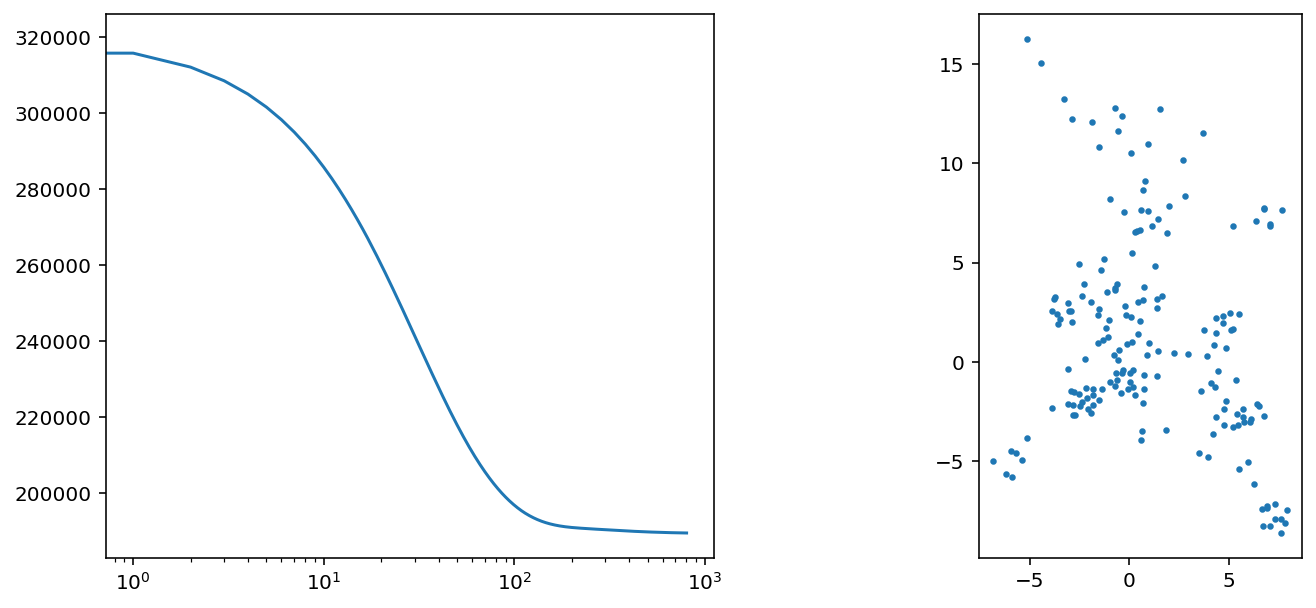

In [65]:
layout.train(gcn_steps=0, fdl_steps=MAX_FDL_STEPS, 
          early_stop_check_steps = 100, 
          min_steps=200, 
          gcn_stop_threshold = GCN_STOP_THRESHOLD,
          fdl_stop_threshold = .1*FDL_STOP_THRESHOLD,
         )

figure(figsize=(12,5))
subplot(121)
plot(layout.loss_history)
xscale('log')
subplot(122, aspect='equal')
plot_layout(layout, edges=False, node_kws={'s':5})

In [ ]:
layout.loss_history[-1]

1220.1298828125

In [ ]:
layout.loss_history[-1]

1220.1298828125

In [ ]:
lin_loss_1 = layout.loss_history

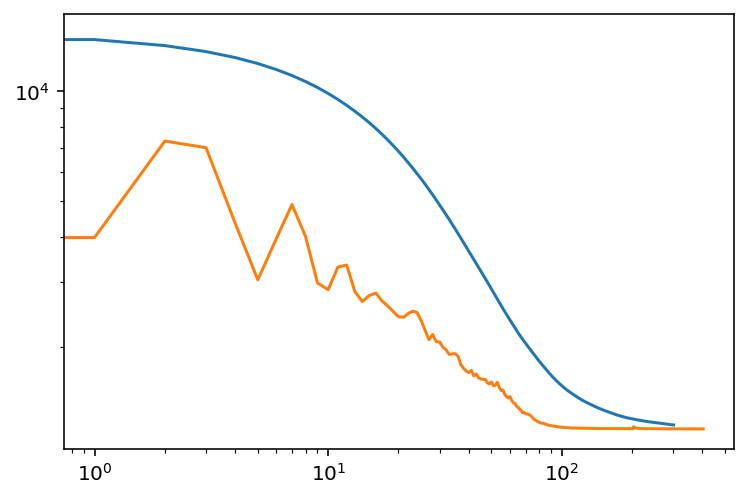

In [ ]:
plot(lin_loss_1)
plot(gcn_loss)

xscale('log')
yscale('log')

In [ ]:
layout = ResGCN(feat_dims=[10,10, DIMENSIONS], A= identity, edge_index=edge_index, lr=1e-1, GCN_class='GCNConv')

In [ ]:
layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, 
          early_stop_check_steps = 100, 
          min_steps=200, 
          gcn_stop_threshold = GCN_STOP_THRESHOLD,
          fdl_stop_threshold = FDL_STOP_THRESHOLD,
         )

figure(figsize=(12,5))
subplot(121)
plot(layout.loss_history)
xscale('log')
subplot(122, aspect='equal')
plot_layout(layout, edges=False, node_kws={'s':5})

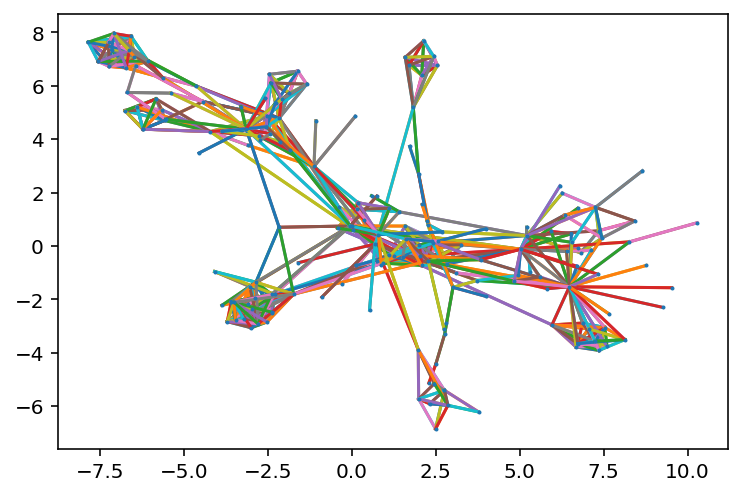

In [66]:
x = layout.get_node_pos()
scatter(*V(x).T[[2,0]], zorder = 10, s= 1)
for i,j in  zip(*torch.where(a)):
            plot(*V(x[[i.item(),j.item()]]).T[[2,0]])


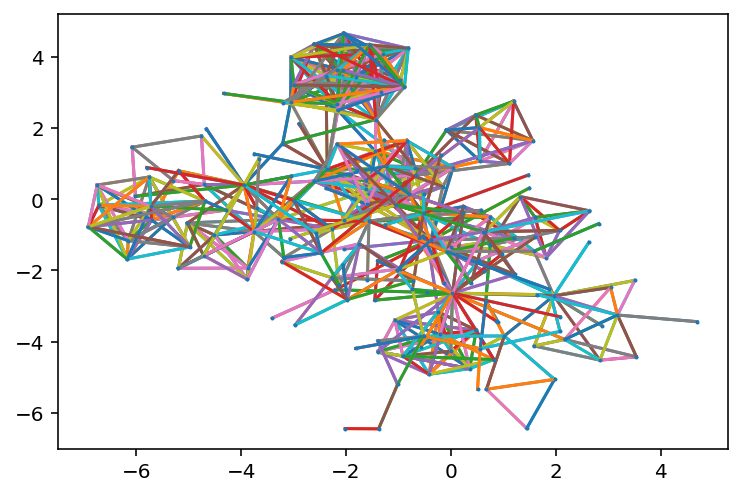

In [74]:
x = layout.get_node_pos()
scatter(*V(x).T[[1,2]], zorder = 10, s= 1)
for i,j in  zip(*torch.where(a)):
            plot(*V(x[[i.item(),j.item()]]).T[[1,2]])


## Node positions 

In [ ]:
# N x dims
node_positions = layout.get_node_pos()

In [ ]:
node_positions

# Saving layout as CSV

In [ ]:
layout.save_layout('./test')

# Old-fashioned FDL
Also works well, but early stopping needs some tuning.  

In [ ]:
layout = ResGCN(feat_dims=[DIMENSIONS], A=a,lr=1e-1, GCN_class=GCN_Lowrank)

In [ ]:
layout.train(gcn_steps=0, fdl_steps=MAX_FDL_STEPS, 
          early_stop_check_steps = 100, 
          min_steps=200, 
          gcn_stop_threshold = GCN_STOP_THRESHOLD,
          fdl_stop_threshold = FDL_STOP_THRESHOLD,
         )

figure(figsize=(12,5))
subplot(121)
plot(layout.loss_history)
xscale('log')
subplot(122, aspect='equal')
plot_layout(layout, edges=False, node_kws={'s':5})

In [ ]:
layout.train(gcn_steps=0, fdl_steps=MAX_FDL_STEPS, 
          early_stop_check_steps = 100, 
          min_steps=200, 
          gcn_stop_threshold = GCN_STOP_THRESHOLD,
          fdl_stop_threshold = 2*FDL_STOP_THRESHOLD,
         )

figure(figsize=(12,5))
subplot(121)
plot(layout.loss_history)
xscale('log')
subplot(122, aspect='equal')
plot_layout(layout, edges=False, node_kws={'s':5})